# SQL Agent 

As a AI engineer, your managers came up with a specific mission: 

- Create a chatbot that can query a SQL DB with simple natural language 

This way managers won't have to go through the Data Analysis team to ask for simple dashboards. They will be able to do it themselves! 

So let's build that Chatbot 💪 🤖

### Step 0 - Demo setup 

For this demo to run, we advise you to: 

1. Run a docker container with the following image:

```bash
docker run -v $(pwd):/home/jovyan -p 8888:8888 jupyter/datascience-notebook
```

2. Then install the following libraries:

In [1]:
# If that's not the case, don't forget to install the following libraries
# !pip install langchain -q
# !pip install langchain-community -q 
# !pip install langchain_mistralai -q
# !pip install langserve -q
# !pip install langgraph -q
# !pip install transformers -q
# !pip install --upgrade typing_extensions -q 

### Step I - Create a model

Let's first instanciate a model. For that query, we definitely advise you to use a larger model or even **Codestral** that is specialized in writting code. 

In [ ]:
# Don't forget this ;)
#%env MISTRAL_API_KEY=

env: MISTRAL_API_KEY=jd8QedSnyVt4D2nGdazTTghFBP7lc2Jg


In [3]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="mistral-large-latest")

### Step II - Create an agent with memory 

Now let's first create an agent with basic memory. 

1. Using the following system prompt :

"You are an agent designed to interact with a SQL database.

Given an input question, create a syntactically correct SQLlite query to run, then look at the results of the query and return the answer.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 50 results.

You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for the relevant columns given the question.

You have access to tools for interacting with the database.

Only use the below tools. Only use the information returned by the below tools to construct your final answer.

You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.

Do NOT skip this step.

Then you should query the schema of the most relevant tables.
"

Create a `call_model` function that creates a `ChatPromptTemplate` instance called `start_prompt`, then chains `start_prompt`, and the llm model, and finally invokes the chain on an input message.

<Note type="tip">

Don't forget to have a system prompt that accepts `MessagesPlaceholder` so that you can actually implement basic memory

</Note>

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState

sys_prompt="""
You are an agent designed to interact with a SQL database.

Given an input question, create a syntactically correct SQLlite query to run, then look at the results of the query and return the answer.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 50 results.

You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for the relevant columns given the question.

You have access to tools for interacting with the database.

Only use the below tools. Only use the information returned by the below tools to construct your final answer.

You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.

Do NOT skip this step.

Then you should query the schema of the most relevant tables.
"""

# Let's create a simple model with a system prompt
def call_model(state: MessagesState):
    # Intanciate the system prompt
    start_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=sys_prompt),
        MessagesPlaceholder("messages"),  # This is where the additional messages will be added
        ])
    
    # Chain the system prompt with Mistral LLM model
    model = start_prompt | llm

    # Here we need to provide a dictionnary with all the messages
    response = model.invoke({"messages":state["messages"]})
    return {"messages": response} 


2. Wrap the `call_model` function in a graph, add memory like we did in the demo, and display the graph.

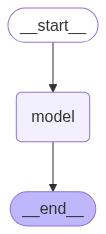

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# LangGraph uses the concepts of graphs which corresponds to a workflow 
# The first thing you need to do is to instanciate that graph using StateGraph.
# StateGraph needs to be provided a schema meaning the data it is expected to handle that is called states
# A State corresponds to the data stored at a given moment in your graph as well as functions (called "reducers") 
# which purpose is to update the State.
# In our case, we use MessagesState which is pre-configured State meant for messages
workflow = StateGraph(state_schema=MessagesState)

# This part defines a single node and an edge
# an Edge is simply the "how" we get from one node to the other one
# I like LangGraph short definition: "nodes do the work. edges tell what to do next."
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# This is stored in RAM of the computer. 
# This is not ideal for production and large conversation history where you will need to define a PostgreSQL DB (more on the later on)
memory = MemorySaver()

# Store the whole graph 
app = workflow.compile(checkpointer=memory)


from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

3. Test your model to see if everything works correctly so far: to do that you will need to feed your graph a message prompt such as "Give me all the movies from the table movies".

In [6]:
from langchain_core.messages import HumanMessage

# Define the configuration for the workflow
config = {"configurable": {"thread_id": "test_thread"}}


user_message = [
    HumanMessage("Give me all the movies from the table movies")
]

# Run the workflow
output = app.invoke({"messages": user_message}, config)

# Display the result
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

To assist you, I need to first understand the structure of the database. Let's start by listing all the tables in the database.

```sql
.tables
```

After identifying the relevant tables, I will query the schema of the `movies` table to understand its structure.

```sql
PRAGMA table_info(movies);
```

Once I have the schema, I will construct a query to retrieve the movie titles from the `movies` table. Let's proceed with these steps.


### Step III - Install `imdb-sqlite`

Our model is working, however it's missing one essential element: a knowledge database!
To simplify this exercise, we'll install the IMDB databases locally on our machine, instead of querying an online database. Simply run:

In [7]:
!pip install imdb-sqlite

In [8]:
# This part will take about 10 min to import, so feel free to have a ☕️ break
# 🚨 CAREFUL you need around 5Go of storage for this to work
!imdb-sqlite 

2025-05-15 18:04:23,793 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2025-05-15 18:04:27,011 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2025-05-15 18:04:29,516 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2025-05-15 18:04:34,685 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2025-05-15 18:04:43,739 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2025-05-15 18:04:44,743 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2025-05-15 18:04:45,009 Populating database: imdb.db
2025-05-15 18:04:45,011 Applying schema
2025-05-15 18:04:45,012 Importing file: downloads/name.basics.tsv.gz
2025-05-15 18:04:45,012 Reading number of rows ...
2025-05-15 18:04:47,470 Inserting rows into table: people
100%|████████████████████████| 14409911/14409911 [00:30<00:00, 467459

### Step IV - Create a SQLlite connection 

Now to interact with `SQLLite` DB, you will need to create a connection. 

<Note type="tip">

Some tips:

* Go back to your course on SQLAlchemy to know how to create a connection
* By default, the sqllite connection is `sqlite:///imdb.db` 
* `pandas` is great for SQL Query

</Note>

Test your connection by querying the first ten records from the `titles`table.

In [9]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///imdb.db', echo=False) #Echo=False removes the Logging INFO (less verbose basically)

df = pd.read_sql("SELECT * FROM titles LIMIT 10", con=engine)
df

,title_id,type,primary_title,original_title,is_adult,premiered,ended,runtime_minutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,None,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,None,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,None,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,None,1,Short
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,None,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,None,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,None,1,"Documentary,Short"
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,None,45,Romance
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,None,1,"Documentary,Short"


### Step V - Import `SQLDatabaseToolkit`

Now let's instanciate `SQLDatabaseToolkit`, and use method `.get_tools` to list out all available tools with their description.

In [10]:
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

db = SQLDatabase(engine)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
toolkit.get_tools()

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x109b8b890>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x109b8b890>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x109b8b890>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

### Step VI - Now build the Agent!

1. Let's build the agent that will query that database, for this we'll start by binding our freshly imported tools to our llm model:

In [11]:
from langgraph.prebuilt import ToolNode, tools_condition

## Bind tool
powered_llm = llm.bind_tools(toolkit.get_tools()) 

2. Now define a new `call_model` function by replacing the simple model with the tool-powered model.

In [12]:
# Let's create a simple model with a system prompt
def call_model(state: MessagesState):
    # Intanciate the system prompt
    start_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=sys_prompt),
        MessagesPlaceholder("messages"),  # This is where the additional messages will be added
        ])
    
    # Chain the system prompt with Mistral LLM model
    model = start_prompt | powered_llm

    # Here we need to provide a dictionnary with all the messages
    response = model.invoke({"messages":state["messages"]})
    return {"messages": response} 


3. Define a new graph that will include a starting point, the model, and finally a `tools` node using an instance of the `ToolNode` class.

In more details the graph should contain:
* A start edge
* A model node
* A tools node
* A conditional edge starting from node model
* An edge from node tools to node model

Do not forget to add memory to your graph.

Finally display the graph.

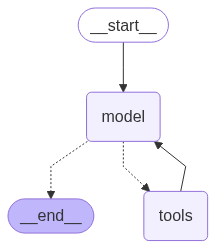

In [13]:
# Create a graph
workflow = StateGraph(state_schema=MessagesState)

# THIS IS NEW 👋
# Here we will be using the `ToolNode` class to build the node that uses the tool we set above
# The ToolNode class is extremely useful because it's an abstraction layer that takes care of the 
# Node logic for us. However, you could have created your own custom logic. If you want to see how to do it
# Feel free to read more here: https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-2-enhancing-the-chatbot-with-tools
tool_node = ToolNode(tools=toolkit.get_tools())

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Here we just add another node into our graph. 
# Careful not to confuse ToolNode that builds the Node logic (python function basically that will handle the "what to do")
# with the .add_node() which adds the node to our current graph 
workflow.add_node("tools", tool_node) 

# THIS IS NEW 👋
# Here we will add a conditional edge. 
# This means that the graph will follow this edge ONLY if the model has called the tool 
# If .tool_calls attribute is not empty then we will go to the tool node 
# Otherwise graph will simply stay at the "model" node
workflow.add_conditional_edges(
    "model",
    tools_condition # This is a pre-built python function that makes the graph go to the ToolNode if .tool_calls is not empty (more here: https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.InjectedStore)
)

workflow.add_edge("tools", "model")

# You already know below
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


4. Test your graph with the following prompt:

"What are the top 5 best movies of all time?"

In [15]:
# Define the configuration for the workflow
config = {"configurable": {"thread_id": "prod_thread1"}}

query = """
What are the top 5 best movies of all time?
"""

user_message = [
    HumanMessage(query)
]

# Run the workflow
# output = app.invoke({"messages": user_message}, config)

for event in app.stream(
    {"messages": [("user", query)]},
    stream_mode="values",
    config=config
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================


What are the top 5 best movies of all time?

================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (mjng4KSHT)
 Call ID: mjng4KSHT
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

akas, crew, episodes, people, ratings, titles
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (HCu7SYHle)
 Call ID: HCu7SYHle
  Args:
    table_names: akas, crew, episodes, people, ratings, titles
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE akas (
	title_id VARCHAR, 
	title VARCHAR, 
	region VARCHAR, 
	language VARCHAR, 
	types VARCHAR, 
	attributes VARCHAR, 
	is_original_title INTEGER
)

/*
3 rows from akas table:
title_id	title	region	language	types	attrib

## STEP VII - Wanna a know a simpler way of creating agents? 🤫


<Note type="hint">

In the lectures, we showed you the most general way of creating agents. However, as you can see, a lot of agents follow the simple graph: START -> MODEL -> TOOLS -> END 

So fortunately for us, Langchain actually create a `create_react_agent` method that build that for us in just one line 😲

Check the documentation and use it for yourself! 

[`create_react_agent`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)

</Note>

In [17]:
from langgraph.prebuilt import create_react_agent

# This replaces the whole agent building phase 😉
# This is awesome when you want to build the classic graph: START -> MODEL -> TOOL -> END 
agent_executor = create_react_agent(
    llm, toolkit.get_tools(), state_modifier=sys_prompt
)

query = """
What are the top 5 best movies of all time?
"""

events = agent_executor.stream(
    {"messages": [("user", query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================


What are the top 5 best movies of all time?

================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (E1CEqv6gM)
 Call ID: E1CEqv6gM
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

akas, crew, episodes, people, ratings, titles
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (jSXzbz126)
 Call ID: jSXzbz126
  Args:
    table_names: akas, crew, episodes, people, ratings, titles
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE akas (
	title_id VARCHAR, 
	title VARCHAR, 
	region VARCHAR, 
	language VARCHAR, 
	types VARCHAR, 
	attributes VARCHAR, 
	is_original_title INTEGER
)

/*
3 rows from akas table:
title_id	title	region	language	types	attrib